In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import keras
from keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPooling2D, Input, Conv2DTranspose, Concatenate, BatchNormalization, UpSampling2D
from keras.layers import  Dropout, Activation, concatenate, Cropping2D, SpatialDropout2D
from keras.optimizers import Adam, SGD, RMSprop
from keras.layers import ELU, PReLU, LeakyReLU
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.metrics import BinaryAccuracy, Precision, Recall
from keras import backend as K
from keras.utils import plot_model
import tensorflow as tf
import glob
import random
import cv2
from random import shuffle
from tensorflow.keras import backend as K
import math
from keras import regularizers
from datetime import datetime

In [ ]:
print("GPUs disponíveis:", tf.config.list_physical_devices('GPU'))

GPUs disponíveis: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
# VARIAVEIS GERAIS

img_sz_x = 256
img_sz_y = 256

batch_size = 16

entrada = "datasets"
#entrada = "saida"

# dataset = ""
dataset = "Originais"

# dataset = "ref1/ED"
# dataset = "ref1/KL"
# dataset = "ref1/Li"
# dataset = "ref1/Perez-Bueno"
# dataset = "ref1/Renyi"
# dataset = "ref1/Tosta"
# dataset = "ref1/Vahadane"

# dataset = "ref2/ED"
# dataset = "ref2/KL"
# dataset = "ref2/Li"
# dataset = "ref2/Perez-Bueno"
# dataset = "ref2/Renyi"
# dataset = "ref2/Tosta"
# dataset = "ref2/Vahadane"

# dataset = "ref3/ED"
# dataset = "ref3/KL"
# dataset = "ref3/Li"
# dataset = "ref3/Perez-Bueno"
# dataset = "ref3/Renyi"
# dataset = "ref3/Tosta"
# dataset = "ref3/Vahadane"

protoseg_online = False

In [ ]:
class ProtoSeg(tf.keras.Model):
    def __init__(self,ndims='2d'):
        super().__init__()

        # for 1D: self.dims=(2)
        # for 2D image: self.dims=(2,3)
        # for 3D image: self.dims=(2,3,4)
        if ndims == '1d':
            self.dims = (2)
        elif ndims == '2d':
            self.dims = (2,3)
        elif ndims == '3d':
            self.dims = (2,3,4)
        else:
            raise ValueError('ndims must be in [1d,2d,3d]')

        #self.softmax = nn.Softmax(dim=1)

    def softmax(self, x):
        return tf.nn.softmax(x)

    def call(self,xfeat,pred,mask=None):
        #@ xfeat: the deep feature need to be inperpreted
        #@ pred: the initial segmentation results from the last layer of the network
        #@ mask is to maks out the background of the image (without any tissue)

        if mask is not None:
            pos_prototype = tf.reduce_sum(xfeat*pred*mask,dim=self.dims,keepdim=True)
            num_prototype = tf.reduce_sum(pred*mask,dim=self.dims,keepdim=True)
            pos_prototype = pos_prototype / num_prototype

            rpred = 1 - pred

            neg_prototype = tf.reduce_sum(xfeat*rpred*mask,dim=self.dims,keepdim=True)
            num_prototype = tf.reduce_sum(rpred*mask,dim=self.dims,keepdim=True)
            neg_prototype = neg_prototype / num_prototype

            pfeat = -tf.reduce_sum((xfeat - pos_prototype)**2, axis=1, keepdims=True)
            nfeat = -tf.reduce_sum((xfeat - neg_prototype)**2, axis=1, keepdims=True)

            disfeat = tf.concat([nfeat, pfeat], axis=1)
            pred = self.softmax(disfeat)

        else:
            xfeat = tf.cast(xfeat, tf.float32)
            pred = tf.cast(pred, tf.float32)

            pos_prototype = tf.reduce_sum(xfeat*pred)
            num_prototype = tf.reduce_sum(pred)
            pos_prototype = pos_prototype / num_prototype

            rpred = 1 - pred
            rpred = tf.cast(rpred, tf.float32)

            neg_prototype = tf.reduce_sum(xfeat*rpred)
            num_prototype = tf.reduce_sum(rpred)
            neg_prototype = neg_prototype / num_prototype

            pfeat = -tf.reduce_sum((xfeat - pos_prototype)**2, axis=1, keepdims=True)
            nfeat = -tf.reduce_sum((xfeat - neg_prototype)**2, axis=1, keepdims=True)

            disfeat = tf.concat([nfeat,pfeat], axis=1)
            pred = self.softmax(disfeat)

        return pred

In [ ]:
from random import shuffle
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from PIL import Image
import cv2

current_X = {}
current_Y = {}

def image_generator(group, files, batch_size = 4, sz = (img_sz_x, img_sz_y), mendeley=False):
    global current_X, current_Y

    while True:
        #extract a random batch
        batch = np.random.choice(files, size = batch_size)

        #variables for collecting batches of inputs and outputs
        batch_x = []
        batch_y = []

        for f in batch:

            #get the masks. Note that masks are png files
            mask = Image.open(f'{entrada}/{dataset}/{group}/mascaras/{f}.png')
            mask = np.array(mask.resize(sz))
            mask = np.expand_dims(mask, axis=-1)

            #preprocess the mask
            mask[mask > 0] = 1
            batch_y.append(mask)

            # Carregar a imagem
            raw = Image.open(f'{entrada}/{dataset}/{group}/{f}.png')
            raw = np.array(raw.resize(sz))
            raw = np.array(raw)

            #check the number of channels because some of the images are RGBA or GRAY
            if len(raw.shape) == 2:
              raw = np.stack((raw,)*3, axis=-1)

            raw = raw[:, :, 0:3]

            batch_x.append(raw)

        #preprocess a batch of images and masks
        batch_x = np.array(batch_x)/255.
        batch_y = np.array(batch_y)
        #batch_y = np.expand_dims(batch_y,3)

        if group == "train":
          current_X = batch_x[0]
          current_Y = batch_y[0]

        yield (batch_x, batch_y)

In [ ]:
import os

train_files = list(os.path.splitext(file)[0] for file in os.listdir(f'{entrada}/{dataset}/train') if os.path.isfile(os.path.join(f'{entrada}/{dataset}/train', file)))
val_files = list(os.path.splitext(file)[0] for file in os.listdir(f'{entrada}/{dataset}/val') if os.path.isfile(os.path.join(f'{entrada}/{dataset}/val', file)))
test_files = list(os.path.splitext(file)[0] for file in os.listdir(f'{entrada}/{dataset}/test') if os.path.isfile(os.path.join(f'{entrada}/{dataset}/test', file)))

print("TOTAL IMAGENS:", len(train_files) + len(val_files) + len(test_files))
print("SPLIT TREINO:", len(train_files))
print("SPLIT VALIDACAO:", len(val_files))
print("SPLIT TESTE:", len(test_files))


train_generator = image_generator("train", train_files, batch_size = batch_size)
val_generator  = image_generator("val", val_files, batch_size = math.floor(batch_size))
test_generator  = image_generator("test", test_files, batch_size = math.floor(len(test_files)/4))

TOTAL IMAGENS: 2051
SPLIT TREINO: 1852
SPLIT VALIDACAO: 66
SPLIT TESTE: 133


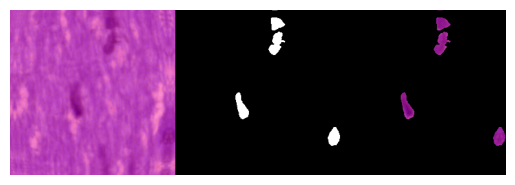

In [ ]:
x, y= next(train_generator)

plt.axis('off')

img = x[0]
msk = y[0].squeeze()
msk = np.stack((msk,)*3, axis=-1)

plt.imshow( np.concatenate([img, msk, img*msk], axis = 1))

In [ ]:
@tf.function
@keras.saving.register_keras_serializable()
def mean_iou(y_true, y_pred):
    yt0 = tf.cast(y_true[:,:,:,0], tf.float32)  # Converter para float32
    yp0 = tf.cast(y_pred[:,:,:,0] > 0.5, tf.float32)  # Já está como float32
    inter = tf.math.count_nonzero(tf.logical_and(tf.equal(yt0, 1), tf.equal(yp0, 1)))
    union = tf.math.count_nonzero(tf.add(yt0, yp0))  # Ambos agora são float32
    iou = tf.where(tf.equal(union, 0), 1.0, tf.cast(inter / union, tf.float32))
    return iou

In [ ]:
# DROPOUT ESPACIAL

def unet(sz = (img_sz_x, img_sz_y, 3), learning_rate=0.001):
  inputs = Input(sz)

  # Definindo a regularização L2
  l2_reg = 0.001

  # Encoder (Downsampling)
  conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
  conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
  pool1 = MaxPooling2D((2, 2))(conv1)

  conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
  conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
  drop2 = SpatialDropout2D(0.50)(conv2)
  pool2 = MaxPooling2D((2, 2))(drop2)

  conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
  conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
  drop3 = SpatialDropout2D(0.50)(conv3)
  pool3 = MaxPooling2D((2, 2))(drop3)

  conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
  conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
  drop4 = SpatialDropout2D(0.50)(conv4)
  pool4 = MaxPooling2D((2, 2))(drop4)

  # Bottleneck
  conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
  conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)
  drop5 = SpatialDropout2D(0.50)(conv5)

  # Decoder (Upsampling)
  up6 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(drop5)
  merge6 = concatenate([up6, drop4], axis=3)
  conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(merge6)
  conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

  up7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv6)
  merge7 = concatenate([up7, drop3], axis=3)
  conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(merge7)
  conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

  up8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv7)
  merge8 = concatenate([up8, drop2], axis=3)
  conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(merge8)
  conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

  up9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv8)
  merge9 = concatenate([up9], axis=3)
  conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(merge9)
  conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

  # Output Layer
  output = Conv2D(1, (1, 1), activation='sigmoid')(conv9)  # Sigmoid para segmentação binária

  model = Model(inputs, output)
  return model

In [ ]:
@tf.function
def dice_score(mask_true, mask_pred): ### IMPORTANTE: TESTAR TROCAR A METRICA PRA IOU E ACURÁCIA
    mask_true = tf.cast(mask_true, tf.float32)
    mask_pred = tf.cast(mask_pred, tf.float32)
    intersection = tf.reduce_sum(mask_true * mask_pred)
    dice = (2.0 * intersection) / (tf.reduce_sum(mask_true) + tf.reduce_sum(mask_pred))
    return dice

@tf.function
@keras.saving.register_keras_serializable()
def SA_score(y_true, y_pred): # images, masks, outputs, feature_extractor
    with tf.device('/GPU:0'):
      img = current_X
      mask = y_true
      output = current_Y #Assim funciona em treino e teste
      #output = y_true

      feature_extractor = Model(
        inputs=model.inputs,
        outputs=model.layers[-1].output,
      )

      x = tf.reshape(img, (1, 256, 256, 3))
      features = feature_extractor(x)
      x = tf.transpose(features, (0, 3, 1, 2))
      #pred_map = tf.transpose(output[i], (0, 3, 1, 2)) # (32, 256, 256, 1) -> (32, 1, 256, 256)
      #pred_map = tf.reshape(pred_map, (batch_size, 256, 256))

      #x = tf.reshape(img[i], (1, 256, 256, 3))
      #x = tf.reshape(y_pred, (1, 256, 256, 1))
      #features = feature_extractor(x)
      #x = tf.transpose(features, (0, 3, 1, 2))
      #x = tf.transpose(x, (0, 3, 1, 2))

      pred_map = tf.transpose(output, (2, 0, 1)) # (256, 256, 1)
      pred_map = tf.reshape(pred_map, (1, 1, 256, 256))

      shape = int(x.shape[2])

      if shape != 256:
          x = tf.image.resize(x, size=(256, 256), method='bilinear')

      neters = ProtoSeg(ndims='2d')
      probability_map = neters(x, pred_map, mask=None)
      binary_map = tf.argmax(probability_map, 1)

      bmap = tf.transpose(binary_map, (1, 2, 0))

      #print("binary_map", binary_map.shape)
      #print("bmap", bmap.shape)
      #print("mask", mask.shape)

      sa_score = dice_score(mask[0], bmap)

      if tf.reduce_any(tf.math.is_nan(sa_score)):
        sa_score = tf.constant(0, dtype=tf.float32)


      return sa_score

In [ ]:
@tf.function
@keras.saving.register_keras_serializable()
def custom_loss(y_true, y_pred):
    # Exemplo simples: entropia cruzada binária
    sa_score = SA_score(y_true, y_pred)

    loss = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    return tf.add(loss, sa_score)

In [ ]:
#lr = 0.001
lr = 0.0001

optimizer = Adam(learning_rate=lr)
model = unet(sz=(256, 256, 3), learning_rate=lr)
if protoseg_online:
  model.compile(optimizer = optimizer, loss=custom_loss, metrics = [mean_iou, BinaryAccuracy(), Precision(), Recall()]) # PROTOSEG ONLINE
  modelo = f"Unet_Protoseg_{dataset.replace('/', '_')}"
else:
  model.compile(optimizer = optimizer, loss='binary_crossentropy', metrics = [mean_iou, BinaryAccuracy(), Precision(), Recall()]) # PROTOSEG OFFLINE
  modelo = f"Unet_{dataset.replace('/', '_')}"
print(modelo)

Unet_KL


In [ ]:
def build_callbacks():
        checkpointer = ModelCheckpoint(filepath=f'../pesos/{modelo}.weights.h5', verbose=0, save_best_only=True, save_weights_only=True)
        callbacks = [checkpointer, PlotLearning()]
        return callbacks

# inheritance for training process plot
class PlotLearning(keras.callbacks.Callback):

    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.iou = [] # CUSTOM
        self.val_iou = [] # CUSTOM
        self.SA_score = [] # CUSTOM
        self.val_SA_score = [] # CUSTOM
        self.acc = []
        self.val_acc = []
        self.logs = []
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.iou.append(logs.get('mean_iou'))
        self.val_iou.append(logs.get('val_mean_iou'))
        self.SA_score.append(logs.get('SA_score'))
        self.val_SA_score.append(logs.get('val_SA_score'))
        self.acc.append(logs.get('binary_accuracy'))
        self.val_acc.append(logs.get('val_binary_accuracy'))
        self.i += 1

        print('\n',
              '\n #### i=',self.i,'loss=',logs.get('loss'),     '\t val_loss=',     logs.get('val_loss'),
              '\n  ### accuracy=', logs.get('binary_accuracy'), '\t val_accuracy=', logs.get('val_binary_accuracy'),
              '\n   ## mean_iou=', logs.get('mean_iou'),        '\t val_mean_iou=', logs.get('val_mean_iou'),
              '\n    # SA_score=', logs.get('SA_score'),        '\t val_SA_score=', logs.get('val_SA_score'),
              '\n')

        #choose a random test image and preprocess
        nome = np.random.choice(val_files)
        raw = Image.open(f'{entrada}/{dataset}/val/{nome}.png')

        raw = np.array(raw.resize((img_sz_y, img_sz_x)))/255.
        raw = raw[:,:,0:3]

        #predict the mask
        pred = model.predict(np.expand_dims(raw, 0))

        #mask post-processing
        msk  = pred.squeeze()
        msk = np.stack((msk,)*3, axis=-1)
        msk[msk >= 0.5] = 1
        msk[msk < 0.5] = 0

In [ ]:
inicio = datetime.now()
print(f"Início: {inicio}")

train_steps = 20
val_steps = 6
model_train = model.fit(train_generator,
                    epochs = 200, steps_per_epoch = train_steps,validation_data = val_generator, validation_steps = val_steps,
                    callbacks = build_callbacks(), verbose = 1)

fim = datetime.now()
print(f"Fim: {fim}")

# Calcular e exibir o tempo de execução
tempo_total = fim - inicio
print(f"Tempo de execução: {tempo_total}")

Início: 2025-02-19 21:49:41.414834
Epoch 1/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - binary_accuracy: 0.8044 - loss: 0.6718 - mean_iou: 0.0284 - precision: 0.1592 - recall: 0.0554
 
 #### i= 1 loss= 0.6248819231987 	 val_loss= 0.4346933662891388 
  ### accuracy= 0.8258171081542969 	 val_accuracy= 0.8489368557929993 
   ## mean_iou= 0.009281356818974018 	 val_mean_iou= 0.0 
    # SA_score= None 	 val_SA_score= None 

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 63s 734ms/step - binary_accuracy: 0.8054 - loss: 0.6696 - mean_iou: 0.0274 - precision: 0.1592 - recall: 0.0536 - val_binary_accuracy: 0.8489 - val_loss: 0.4347 - val_mean_iou: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - binary_accuracy: 0.8465 - loss: 0.4399 - mean_iou: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00
 
 #### i= 2 loss= 0.42565006017684937 	 val_loss= 0.41801512241363525 
  ### accuracy= 0.8519684076309204 	 

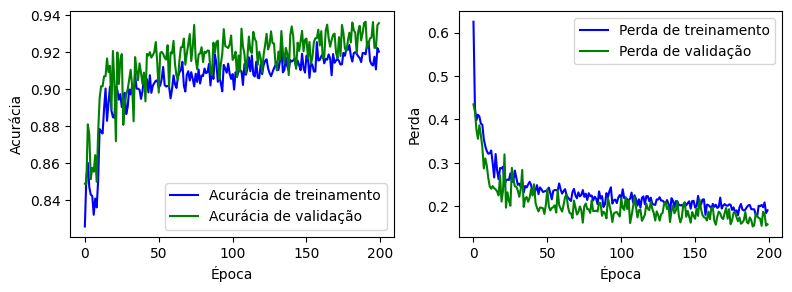

In [ ]:
accuracy = model_train.history['binary_accuracy']
val_accuracy = model_train.history['val_binary_accuracy']
loss = model_train.history['loss']
val_loss = model_train.history['val_loss']

#SA_score = model_train.history['SA_score']
#val_SA_score = model_train.history['val_SA_score']

epochs = range(len(accuracy))

array_zeros = np.zeros(len(accuracy)-len(val_accuracy))

# Concatenando os dois arrays
val_accuracy = np.concatenate((val_accuracy, array_zeros))
val_loss = np.concatenate((val_loss, array_zeros))

fig = plt.figure(figsize=(8, 3))

fig.add_subplot(1, 2, 1)
plt.plot(epochs, accuracy, 'b', label='Acurácia de treinamento')
plt.plot(epochs, val_accuracy, 'g', label='Acurácia de validação')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.legend()
fig.tight_layout(pad=1)

fig.add_subplot(1, 2, 2)
plt.plot(epochs, loss, 'b', label='Perda de treinamento')
plt.plot(epochs, val_loss, 'g', label='Perda de validação')
plt.xlabel('Época')
plt.ylabel('Perda')
plt.legend()
fig.tight_layout(pad=1)

#fig.add_subplot(1, 3, 3)
#plt.plot(epochs, SA_score, 'b', label='SA score de treinamento')
#plt.plot(epochs, val_SA_score, 'g', label='SA score de validação')
#plt.title('SA score de treinamento e validação')
#plt.legend()
#fig.tight_layout(pad=1)

plt.savefig(f"saida/imagens/{modelo}.svg")
plt.savefig(f"saida/imagens/{modelo}.png")

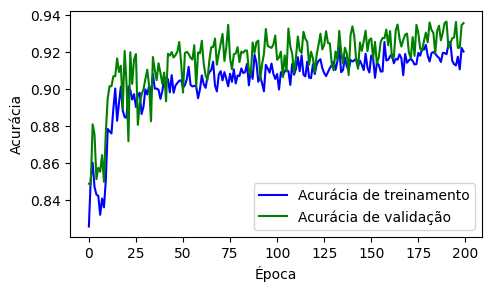

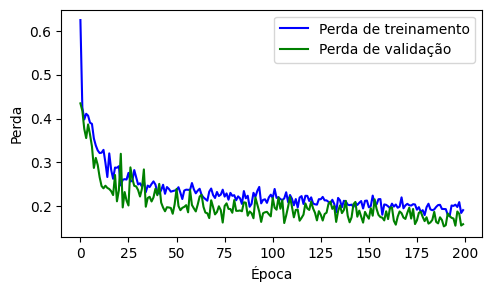

In [ ]:
accuracy = model_train.history['binary_accuracy']
val_accuracy = model_train.history['val_binary_accuracy']
loss = model_train.history['loss']
val_loss = model_train.history['val_loss']

#SA_score = model_train.history['SA_score']
#val_SA_score = model_train.history['val_SA_score']

epochs = range(len(accuracy))

array_zeros = np.zeros(len(accuracy)-len(val_accuracy))

# Concatenando os dois arrays
val_accuracy = np.concatenate((val_accuracy, array_zeros))
val_loss = np.concatenate((val_loss, array_zeros))

fig = plt.figure(figsize=(5, 3))

plt.plot(epochs, accuracy, 'b', label='Acurácia de treinamento')
plt.plot(epochs, val_accuracy, 'g', label='Acurácia de validação')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.legend()
fig.tight_layout(pad=1)

plt.savefig(f"saida/imagens/acuracia_{modelo}.svg")
plt.savefig(f"saida/imagens/acuracia_{modelo}.png")

plt.show()

fig = plt.figure(figsize=(5, 3))
plt.plot(epochs, loss, 'b', label='Perda de treinamento')
plt.plot(epochs, val_loss, 'g', label='Perda de validação')
plt.xlabel('Época')
plt.ylabel('Perda')
plt.legend()
fig.tight_layout(pad=1)

plt.savefig(f"saida/imagens/perda_{modelo}.svg")
plt.savefig(f"saida/imagens/perda_{modelo}.png")

plt.show()

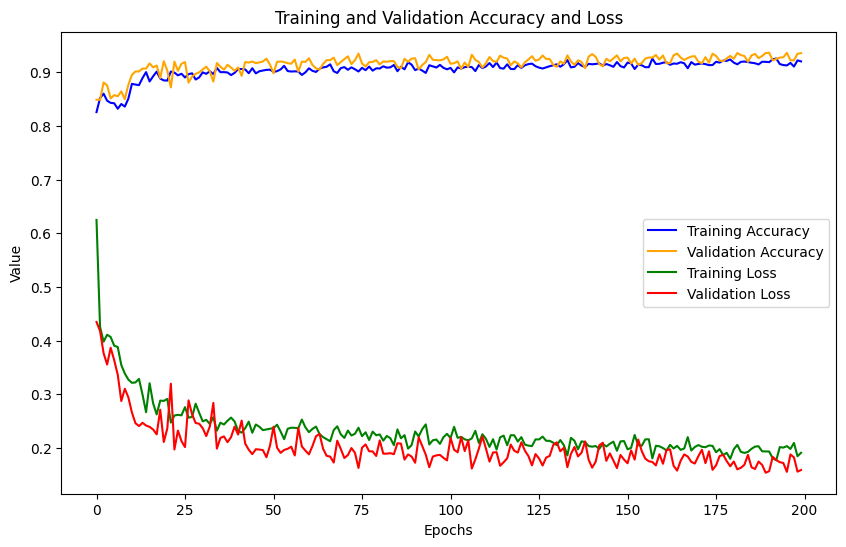

In [ ]:
# Plotar métricas: accuracy, val_accuracy, loss, val_loss, mean_iou, val_mean_iou
def plot_history(history):
    acc = history.history['binary_accuracy']
    val_acc = history.history['val_binary_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.figure(figsize=(10, 6))

    plt.plot(epochs, acc, 'b', label='Training Accuracy')
    plt.plot(epochs, val_acc, color='orange', label='Validation Accuracy')
    plt.plot(epochs, loss, 'g', label='Training Loss')
    plt.plot(epochs, val_loss, 'r', label='Validation Loss')

    plt.title('Training and Validation Accuracy and Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Value')
    plt.legend()

    if not os.path.exists(f"saida/imagens"):
      os.mkdir(f"saida/imagens")

    plt.savefig(f"saida/imagens/{modelo}_2.svg")
    plt.savefig(f"saida/imagens/{modelo}_2.png")

    plt.show()


plot_history(model_train)

In [ ]:
model.save(f"saida/modelos_salvos/{modelo}.h5")

In [ ]:
from keras.models import load_model

model = load_model(f"saida/modelos_salvos/{modelo}.h5",
                    custom_objects={'mean_iou': mean_iou, 'SA_score': SA_score, 'custom_loss': custom_loss})

In [ ]:
x, y= next(test_generator)

masks_teste = model.predict(x)
print("Shape Classes:", masks_teste.shape)

2/2 ━━━━━━━━━━━━━━━━━━━━ 16s 457ms/step
Shape Classes: (33, 256, 256, 1)


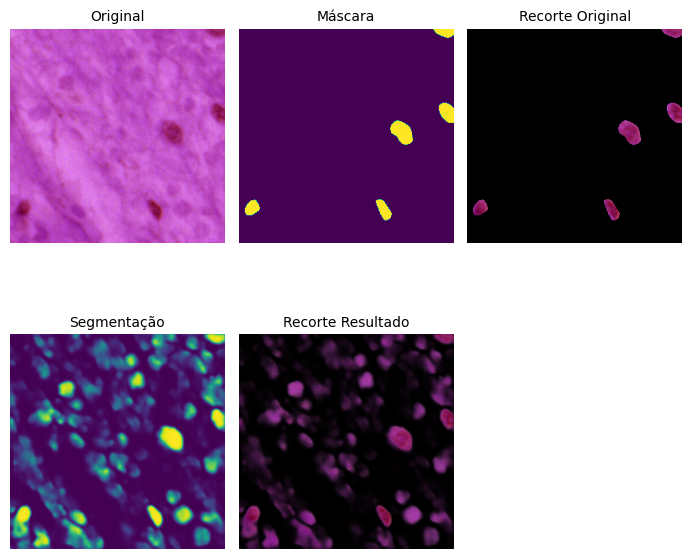

In [ ]:
#plt.axis('off')
img = x[0]
msk = y[0].squeeze()
msk = np.stack((msk,)*3, axis=-1)

msk_t = masks_teste[0].squeeze()
msk_t = np.stack((msk_t,)*3, axis=-1)

fig = plt.figure(figsize=(7, 7))

fig.add_subplot(2, 3, 1)
plt.axis('off')
plt.imshow(img)
plt.title('Original', fontsize=10)
fig.tight_layout(pad=1)

fig.add_subplot(2, 3, 2)
plt.axis('off')
plt.imshow(y[0])
plt.title('Máscara', fontsize=10)
fig.tight_layout(pad=1)

fig.add_subplot(2, 3, 3)
plt.axis('off')
plt.imshow(img*msk)
plt.title('Recorte Original', fontsize=10)
fig.tight_layout(pad=1)

fig.add_subplot(2, 3, 4)
plt.axis('off')
plt.imshow(masks_teste[0])
plt.title('Segmentação', fontsize=10)
fig.tight_layout(pad=1)

fig.add_subplot(2, 3, 5)
plt.axis('off')
plt.imshow(img*msk_t)
plt.title('Recorte Resultado', fontsize=10)
fig.tight_layout(pad=1)

plt.show()

#plt.imshow( np.concatenate([img, msk, img*msk, msk_t, img*msk_t], axis = 1))


In [ ]:
def dice_coefficient(true, pred, smooth=1e-6):
    """
    Calcula o coeficiente de Dice.
    Args:
        true: Máscara verdadeira.
        pred: Máscara predita.
        smooth: Valor pequeno para evitar divisão por zero.
    Returns:
        Dice coefficient.
    """
    intersection = np.sum(true * pred)
    union = np.sum(true) + np.sum(pred)
    dice = (2. * intersection + smooth) / (union + smooth)
    return dice

In [ ]:
def compute_iou(true, pred):
    """
    Computa a Interseção sobre União (IoU) para dois segmentos.
    Args:
        true: Máscara verdadeira.
        pred: Máscara predita.
    Returns:
        IoU: Interseção sobre União.
    """
    intersection = np.logical_and(true, pred)
    union = np.logical_or(true, pred)
    iou = np.sum(intersection) / np.sum(union)
    return iou

def panoptic_quality(true, pred, threshold=0.5):
    """
    Calcula a Panoptic Quality (PQ).
    Args:
        true: Imagem de rótulos verdadeiros.
        pred: Imagem de rótulos preditos.
        threshold: Limiar de IoU para correspondência.
    Returns:
        PQ: Panoptic Quality.
    """
    true_labels = np.unique(true)
    pred_labels = np.unique(pred)

    tp = 0  # True Positives
    fp = 0  # False Positives
    fn = 0  # False Negatives
    sum_iou = 0

    for t in true_labels:
        if t == 0:  # Ignorando o rótulo de fundo
            continue
        matched = False
        for p in pred_labels:
            if p == 0:  # Ignorando o rótulo de fundo
                continue
            iou = compute_iou(true == t, pred == p)
            if iou > threshold:
                tp += 1
                sum_iou += iou
                matched = True
                pred_labels = np.delete(pred_labels, np.where(pred_labels == p))
                break
        if not matched:
            fn += 1

    fp = len(pred_labels) - 1  # Excluindo o fundo

    if tp == 0:
        pq = 0
    else:
        pq = (sum_iou / tp) * (tp / (tp + 0.5 * fp + 0.5 * fn))

    return pq

In [ ]:
def jaccard_index(y_true, y_pred, smooth=1e-10):
    """
    Calcula o índice de Jaccard para segmentação de imagens.

    Args:
        y_true: Tensor de rótulos verdadeiros.
        y_pred: Tensor de previsões.
        smooth: Um valor pequeno para evitar divisão por zero.

    Returns:
        Índice de Jaccard.
    """
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    intersection = tf.reduce_sum(tf.multiply(y_true, y_pred), axis=[1, 2, 3])
    union = tf.reduce_sum(y_true, axis=[1, 2, 3]) + tf.reduce_sum(y_pred, axis=[1, 2, 3]) - intersection

    return tf.reduce_mean((intersection + smooth) / (union + smooth)).numpy()

In [ ]:
def dice_score(mask_true, mask_pred): ### IMPORTANTE: TESTAR TROCAR A METRICA PRA IOU E ACURÁCIA
    mask_true = tf.cast(mask_true, tf.float32)
    mask_pred = tf.cast(mask_pred, tf.float32)
    intersection = tf.reduce_sum(mask_true * mask_pred)
    dice = (2.0 * intersection) / (tf.reduce_sum(mask_true) + tf.reduce_sum(mask_pred))
    return dice

@keras.saving.register_keras_serializable()
def Mean_SA_score(y_true, y_pred, x_true, useOutput=False): # images, masks, outputs, feature_extractor

    #img = current_X
    img = x_true
    mask = y_true
    #output = current_Y
    output = y_true

    feature_extractor = Model(
       inputs=model.inputs,
       outputs=model.layers[-1].output,
    )

    scores = []

    for i in range(img.shape[0]):
        x = tf.reshape(img[i], (1, img_sz_y, img_sz_x, 3))
        if useOutput: # Calcula a partir do Output ou do Segmentation
          features = y_pred[i]
          x = np.transpose(features, (2, 0, 1)).reshape(1, 1, img_sz_y, img_sz_x)
          #x = np.reshape(features, (1, 1, 256, 256))
        else:
          features = feature_extractor(x)
          x = tf.transpose(features, (0, 3, 1, 2))

        #pred_map = tf.transpose(output[i], (0, 3, 1, 2)) # (32, 256, 256, 1) -> (32, 1, 256, 256)
        #pred_map = tf.reshape(pred_map, (batch_size, 256, 256))

        #x = tf.reshape(img[i], (1, 256, 256, 3))
        #x = tf.reshape(y_pred, (1, 256, 256, 1))
        #features = feature_extractor(x)
        #x = tf.transpose(features, (0, 3, 1, 2))
        #x = tf.transpose(x, (0, 3, 1, 2))

        pred_map = tf.transpose(output[i], (2, 0, 1)) # (256, 256, 1)
        pred_map = tf.reshape(pred_map, (1, 1, img_sz_y, img_sz_x))

        shape = int(x.shape[2])

        # if shape != 256:
        #     x = tf.image.resize(x, size=(img_sz_y, img_sz_x), method='bilinear')

        neters = ProtoSeg(ndims='2d')
        probability_map = neters(x, pred_map, mask=None)
        binary_map = tf.argmax(probability_map, 1)

        bmap = tf.transpose(binary_map, (1, 2, 0))

        #print("binary_map", binary_map.shape)
        #print("bmap", bmap.shape)
        #print("mask", mask[i].shape)

        sa_score = dice_score(mask[i], bmap)

        if np.any(tf.math.is_nan(sa_score)):
            sa_score = 0

        scores.append(float(sa_score))

    return (float(tf.reduce_mean(scores)), float(tf.math.reduce_std(scores))) # (media , desvio padrao)

In [ ]:
num_steps = 10
#num_steps = 120
evaluation = model.evaluate(test_generator, steps=num_steps, verbose=-1)

print(modelo)

metricas = [str(x).replace('.', ',') for x in evaluation]
print("Perda:", metricas[0])
print("IOU:", metricas[1])
print("Acurácia:", metricas[2])
print("Precisão:", metricas[3])
print("Recall:", metricas[4])

# print(model.metrics_names)
# print(metricas)

precision = evaluation[3]
recall = evaluation[4]
f1_score = 2 * (precision * recall) / (precision + recall + 1e-7)
f1_score = str(f1_score).replace('.', ',')
print("f1_score:", f1_score)

# y e masks_teste gerados no model.predict
# Convertendo previsões para binárias (ajuste o limiar conforme necessário)
y_pred_bin = (masks_teste > 0.5).astype(np.int32)
y_test_bin = y.astype(np.int32)  # Certifique-se de que y também seja int32
x_test = x

#DICE
# Calculando a métrica Dice para cada imagem no conjunto de teste
dice_scores = [dice_coefficient(true, pred) for true, pred in zip(y_test_bin, y_pred_bin)]
# Média do coeficiente de Dice no conjunto de teste
average_dice = np.mean(dice_scores)
average_dice = str(average_dice).replace('.', ',')
print("Average Dice Coefficient: ", average_dice)

#PQ
# Calculando a métrica Panoptic Quality para cada imagem no conjunto de teste
pq_scores = [panoptic_quality(true, pred) for true, pred in zip(y_test_bin, y_pred_bin)]
# Média da Panoptic Quality no conjunto de teste
average_pq = np.mean(pq_scores)
average_pq = str(average_pq).replace('.', ',')
print("Average Panoptic Quality (PQ): ", average_pq)

#AJI
# Calculando a métrica Aggregate Jaccard Index manualmente
aggregate_jaccard = jaccard_index(y, y_pred_bin)
aggregate_jaccard = str(aggregate_jaccard).replace('.', ',')
print("AJI(Aggregate Jaccard Index):", aggregate_jaccard)

SA_score_mean, SA_score_STD = Mean_SA_score(y_test_bin, y_pred_bin, x_test, useOutput=False)
SA_score_mean = str(SA_score_mean).replace('.', ',')
SA_score_STD = str(SA_score_STD).replace('.', ',')
print("Mean SA Score: ", SA_score_mean)
print("Standard Deviation SA Score: ", SA_score_STD)

SA_score_mean_output, SA_score_STD_output = Mean_SA_score(y_test_bin, y_pred_bin, x_test, useOutput=True)
SA_score_mean_output = str(SA_score_mean_output).replace('.', ',')
SA_score_STD_output = str(SA_score_STD_output).replace('.', ',')
print("Mean SA Score (OUTPUT): ", SA_score_mean_output)
print("Standard Deviation SA Score (OUTPUT): ", SA_score_STD_output)

Unet_KL
Perda: 0,1872822344303131
IOU: 0,6128454804420471
Acurácia: 0,9210835695266724
Precisão: 0,783693253993988
Recall: 0,7366611957550049
f1_score: 0,7594497082113585
Average Dice Coefficient:  0,7286135079033681
Average Panoptic Quality (PQ):  0,5226598355321164
AJI(Aggregate Jaccard Index): 0,58649635
Mean SA Score:  0,6232092380523682
Standard Deviation SA Score:  0,23016609251499176
Mean SA Score (OUTPUT):  0,7286134958267212
Standard Deviation SA Score (OUTPUT):  0,12405678629875183
